## Imports

In [ ]:
! pip install "tsfm_public[notebooks] @ git+ssh://git@github.com/ibm-granite/granite-tsfm.git"

In [ ]:
import os
import sys
# sys.path.append('..')

import math
import torch
import inspect
import tempfile
from tqdm.notebook import tqdm

from ttm_helper import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
    TimeSeriesPreprocessor,
    TinyTimeMixerConfig,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits


import warnings
warnings.filterwarnings("ignore")

INFO:p-21681:t-133519277318272:config.py:<module>:PyTorch version 2.7.0 available.
INFO:p-21681:t-133519277318272:config.py:<module>:JAX version 0.6.0 available.


## Task Specific Configuration


In [153]:
task, filename, target_col, are_features_standardised, shift_target = task_configs["10y_FORECAST"]
DATA_ROOT_PATH = "../data_processed/"
# filename = '10y_yield_forecast_diff.csv'
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Forecasting parameters
context_length = 90
forecast_length = 30
TTM_MODEL_REVISION = f"{context_length}-{forecast_length}-ft-r2.1"
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

# Results dir
OUT_DIR = f"./ttm_finetuned_models/{task}/context-{context_length}-forecast-{forecast_length}"

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare Data

Data lengths: train = 3933, test = 984


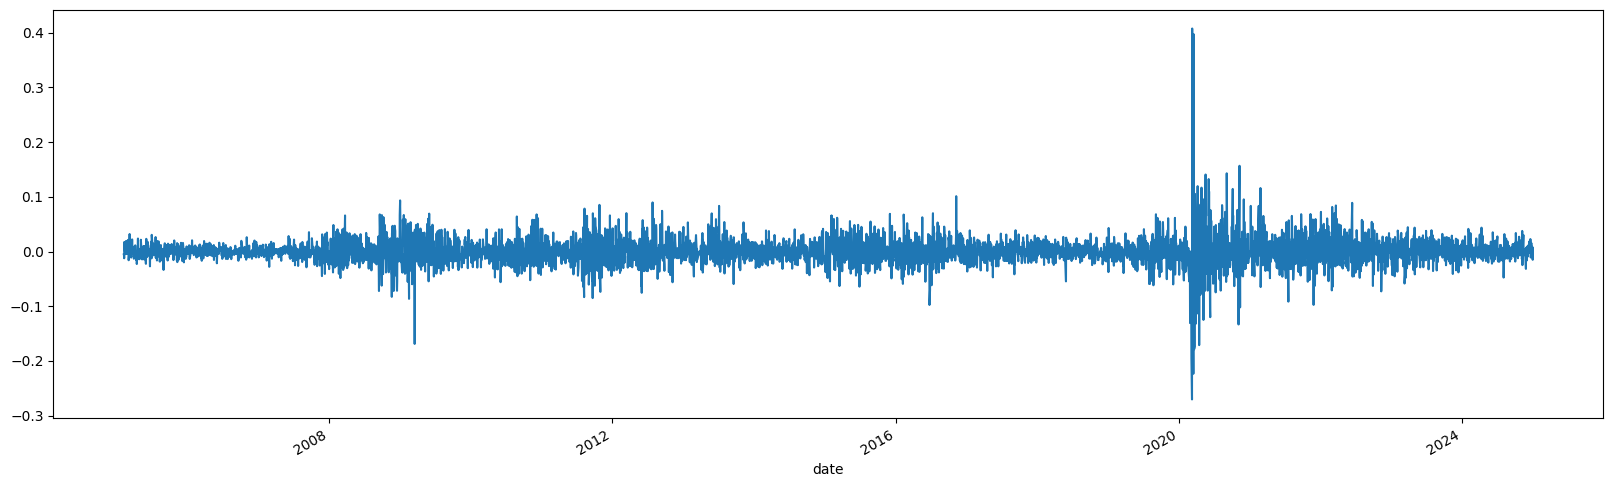

In [154]:
timestamp_column = 'date'
data = pd.read_csv(os.path.join(DATA_ROOT_PATH, filename), parse_dates = [timestamp_column])
df_tsfm = data.copy()

# drop NaNs
df_tsfm = df_tsfm.dropna()
df_tsfm = df_tsfm.rename(columns={target_col: "target"})
df_tsfm = df_tsfm.rename(columns=column_rename_dict)
conditional_columns = df_tsfm.columns.difference(["target"] + [timestamp_column]).tolist()
column_specifiers = {"timestamp_column": timestamp_column,"id_columns": [],"target_columns": ["target"],"conditional_columns": conditional_columns}
split_config = {"train": 1, "test": 0}
train_df, test_df = train_test_split(df_tsfm, train_size=0.8, shuffle=False)

tsp = TimeSeriesPreprocessor(**column_specifiers, context_length=context_length, prediction_length=forecast_length, scaling= not are_features_standardised, encode_categorical=False, scaler_type="standard",)

train_dataset, _, _ = get_datasets(tsp, train_df, split_config, use_frequency_token='B')
print(f"Data lengths: train = {len(train_df)}, test = {len(test_df)}")
df_tsfm.set_index(timestamp_column)["target"].plot(figsize=(20,6));

## Feature Analysis

<Figure size 800x600 with 0 Axes>

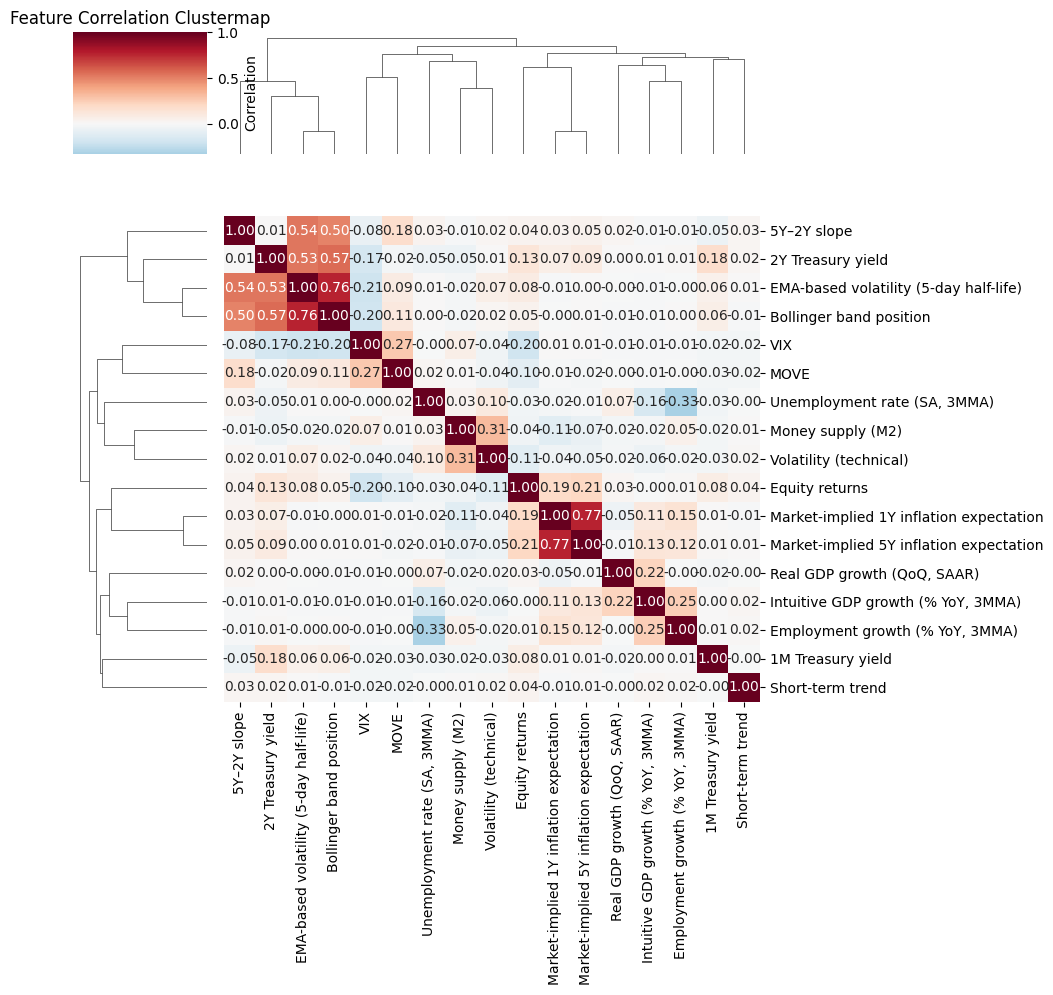

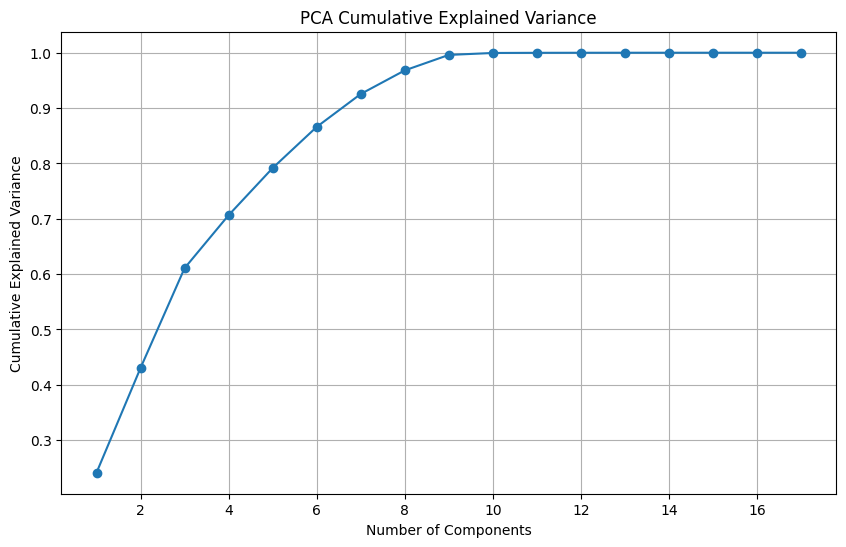

In [155]:
features = (df_tsfm.set_index('date')).drop(columns='target')

# Calculate correlation matrix
corr_matrix = features.corr()

# Create clustermap
plt.figure(figsize=(8, 6))
sns.clustermap(corr_matrix, cmap='RdBu_r',center=0,annot=True,fmt='.2f',square=True,cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Clustermap')
plt.tight_layout()
plt.show()

# PCA Analysis
pca = PCA()
pca_result = pca.fit_transform(features)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)
plt.show()


## Rolling model training and prediction

### TTM

In [171]:
# Important parameters
num_epochs = 20
batch_size = 64
years_of_training_data = 8

start_date = df_tsfm[timestamp_column].iloc[0]
end_date = df_tsfm[timestamp_column].iloc[-1]
years_of_data = end_date.year-start_date.year

# Initialize DataFrames
all_forecasts_ttm = pd.DataFrame(index = data.date, columns=['target_prediction', 'target'])
mse_results = pd.DataFrame(columns=['date', 'pre_trained_fine_tuned_TTM', 'naive_mse'])
corrs = pd.Series()

# Calculate number of 1-year periods
num_periods = int((years_of_data - years_of_training_data) * 4)
step = 63  # Approx. one quarter in business days
context_rows = context_length
train_years = years_of_training_data
train_rows = 252 * train_years  # Approximate trading days in N years

timestamps = df_tsfm[timestamp_column].reset_index(drop=True)
valid_indices = range(train_rows + context_rows, len(df_tsfm) - step, step)

for i in tqdm(valid_indices, desc="Training models"):
    # date = start_date + pd.DateOffset(years=years_of_training_data) + pd.DateOffset(months=3*period)
    date = timestamps[i]

    # Perpare data
    split_config = {"train": 1.0, "test": 0}
    # train_df = df_tsfm[
    #     (df_tsfm[timestamp_column] >= date - pd.DateOffset(years=years_of_training_data)) &
    #     (df_tsfm[timestamp_column] <= date)
    # ]

    # test_df = df_tsfm[
    #     (df_tsfm[timestamp_column] > date - pd.DateOffset(days=context_length)) &
    #     (df_tsfm[timestamp_column] <= date + pd.DateOffset(months=5))
    # ]
    # Training data: N years before the current index (by row count)
    train_start = i - train_rows
    train_end = i - context_rows
    train_df = df_tsfm.iloc[train_start:train_end]

    # Test data: includes context + forecast
    test_start = i - context_rows
    test_end = i + step
    test_df = df_tsfm.iloc[test_start:test_end]

    train_dataset, _, _ = get_datasets(tsp,train_df,split_config,use_frequency_token='B')
    test_dataset, _, _ = get_datasets(tsp,test_df,split_config,use_frequency_token='B')
    
    # Get pretrained model
    finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-r2",revision=TTM_MODEL_REVISION,num_input_channels=tsp.num_input_channels,decoder_mode="mix_channel",prediction_channel_indices=tsp.prediction_channel_indices,exogenous_channel_indices=tsp.exogenous_channel_indices,enable_forecast_channel_mixing=True,fcm_prepend_past=True)
    
    # Fine-Tune Pretrained Model
    learning_rate, finetune_forecast_model = optimal_lr_finder(finetune_forecast_model,train_dataset,batch_size=batch_size,enable_prefix_tuning=False)
    finetune_forecast_args = TrainingArguments(output_dir=os.path.join(OUT_DIR, "output"), overwrite_output_dir=True, learning_rate=learning_rate, num_train_epochs=num_epochs, do_eval=False, per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size, dataloader_num_workers=8, report_to=None, save_strategy="no", logging_strategy="epoch", save_total_limit=1, logging_dir=os.path.join(OUT_DIR, "logs"), load_best_model_at_end=True, metric_for_best_model="eval_loss", greater_is_better=False)
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)))
    rolling_forecast_trainer = Trainer(model=finetune_forecast_model, args=finetune_forecast_args, train_dataset=train_dataset, eval_dataset=test_dataset, optimizers=(optimizer, scheduler))
    rolling_forecast_trainer.train()

    # Predict (pretrained)
    pipeline = TimeSeriesForecastingPipeline(finetune_forecast_model, feature_extractor=tsp, batch_size=batch_size)
    finetune_forecast = pipeline(test_df)
    # finetune_forecast = finetune_forecast.iloc[:-forecast_length]
    processed_forecasts = calculate_21_day_sum(finetune_forecast)
    all_forecasts_ttm.update(processed_forecasts, overwrite=True)


    pre_trained_fine_tuned_TTM = ((processed_forecasts.target-processed_forecasts.target_prediction)**2).mean()
    naive_mse = np.mean(processed_forecasts.target**2)
    corr = processed_forecasts.corr(method='spearman').iloc[0, 1]
    corrs[date] = corr
    
    mse_results = pd.concat([mse_results, pd.DataFrame({
        'date': [date],
        'pre_trained_fine_tuned_TTM': [pre_trained_fine_tuned_TTM],
        'naive_mse': [naive_mse]
    })], ignore_index=True)


actuals = calculate_21_day_ret(pipeline(df_tsfm.iloc[:-forecast_length]))[['target']].dropna()
all_forecasts_ttm.update(actuals, overwrite = True)
all_forecasts_ttm.dropna().to_csv('./forecasts/ttm.csv')


Training models:   0%|          | 0/44 [00:00<?, ?it/s]

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Step,Training Loss
29,0.000600
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000500
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000600
116,0.000600
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000600
116,0.000600
145,0.000600
174,0.000600
203,0.000600
232,0.000600
261,0.000600
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000700
58,0.000600
87,0.000600
116,0.000600
145,0.000600
174,0.000600
203,0.000600
232,0.000600
261,0.000600
290,0.000600


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000600
116,0.000600
145,0.000600
174,0.000600
203,0.000600
232,0.000600
261,0.000600
290,0.000600


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000700
58,0.000600
87,0.000600
116,0.000600
145,0.000600
174,0.000600
203,0.000600
232,0.000600
261,0.000600
290,0.000600


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000600
116,0.000600
145,0.000600
174,0.000600
203,0.000600
232,0.000600
261,0.000600
290,0.000600


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000600
116,0.000600
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000600
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000600
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000500
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000500
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000500
290,0.000500


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000500
58,0.000500
87,0.000500
116,0.000500
145,0.000500
174,0.000500
203,0.000500
232,0.000500
261,0.000400
290,0.000400


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000500
58,0.000400
87,0.000400
116,0.000400
145,0.000400
174,0.000400
203,0.000400
232,0.000400
261,0.000400
290,0.000400


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000500
58,0.000400
87,0.000400
116,0.000400
145,0.000400
174,0.000400
203,0.000400
232,0.000400
261,0.000400
290,0.000400


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000500
58,0.000400
87,0.000400
116,0.000400
145,0.000400
174,0.000400
203,0.000400
232,0.000400
261,0.000400
290,0.000400


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000500
58,0.000400
87,0.000400
116,0.000400
145,0.000400
174,0.000400
203,0.000400
232,0.000400
261,0.000400
290,0.000400


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.000900
58,0.000900
87,0.000900
116,0.000800
145,0.000900
174,0.000800
203,0.000800
232,0.000800
261,0.000800
290,0.000800


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001000
58,0.001000
87,0.001000
116,0.000900
145,0.001000
174,0.000900
203,0.000900
232,0.000900
261,0.001000
290,0.000900


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001100
58,0.001000
87,0.001000
116,0.001000
145,0.001000
174,0.001000
203,0.001000
232,0.001000
261,0.001000
290,0.000900


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001100
58,0.001000
87,0.001000
116,0.001000
145,0.001000
174,0.001000
203,0.001000
232,0.001000
261,0.001000
290,0.001000


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001100
58,0.001100
87,0.001000
116,0.001000
145,0.001000
174,0.001000
203,0.001000
232,0.001000
261,0.001000
290,0.001000


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001100
58,0.001100
87,0.001000
116,0.001100
145,0.001000
174,0.001000
203,0.001000
232,0.001000
261,0.001000
290,0.001000


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001100
58,0.001100
87,0.001100
116,0.001100
145,0.001100
174,0.001100
203,0.001100
232,0.001100
261,0.001000
290,0.001000


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001200
58,0.001100
87,0.001100
116,0.001100
145,0.001100
174,0.001100
203,0.001100
232,0.001100
261,0.001100
290,0.001000


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001200
58,0.001200
87,0.001100
116,0.001100
145,0.001100
174,0.001100
203,0.001100
232,0.001100
261,0.001100
290,0.001100


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001200
58,0.001100
87,0.001100
116,0.001100
145,0.001100
174,0.001200
203,0.001100
232,0.001100
261,0.001100
290,0.001100


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001200
58,0.001200
87,0.001100
116,0.001100
145,0.001100
174,0.001100
203,0.001100
232,0.001100
261,0.001100
290,0.001100


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001300
58,0.001200
87,0.001100
116,0.001200
145,0.001100
174,0.001100
203,0.001100
232,0.001100
261,0.001100
290,0.001100


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001300
58,0.001200
87,0.001200
116,0.001200
145,0.001200
174,0.001300
203,0.001100
232,0.001100
261,0.001100
290,0.001200


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001200
58,0.001100
87,0.001100
116,0.001100
145,0.001100
174,0.001100
203,0.001100
232,0.001100
261,0.001100
290,0.001000


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001200
58,0.001100
87,0.001100
116,0.001100
145,0.001100
174,0.001100
203,0.001100
232,0.001100
261,0.001000
290,0.001000


Device set to use cuda:0
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_

Step,Training Loss
29,0.001100
58,0.001100
87,0.001100
116,0.001100
145,0.001000
174,0.001000
203,0.001000
232,0.001100
261,0.001000
290,0.001000


Device set to use cuda:0


### Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data_path = '../data_raw/treasury_yields'
curve_data = pd.DataFrame(columns=["1 Mo","2 Mo","3 Mo","4 Mo","6 Mo","1 Yr","2 Yr","3 Yr","5 Yr","7 Yr","10 Yr","20 Yr","30 Yr"])
for file in os.listdir(data_path):
    if not file.endswith('.csv'):
        continue
    file_data = pd.read_csv(os.path.join(data_path, file), index_col = 0, parse_dates=True)
    curve_data = pd.concat([curve_data, file_data])
curve_data = curve_data.sort_index()
curve_data = curve_data.apply(pd.to_numeric, errors='coerce')
curve_data = curve_data.drop(columns=['1.5 Month', '2 Mo', '4 Mo'])

features = pd.read_csv('../data_processed/10y_yield_forecast.csv', parse_dates=True, index_col=0)
df_lr = features.copy()
df_lr['10y'] = curve_data['10 Yr'].pct_change(21).shift(-21)
df_lr = df_lr.dropna()

In [246]:
# Initialize results storage
results = {}
years_of_training_data = 8
# Initialize DataFrame to store MSE results
mse_results_linear = pd.DataFrame(columns=['date', 'Linear'])

coefs_history = pd.DataFrame(columns=df_lr.columns.drop('10y'))
linear_corrs = pd.Series()
dates = df_lr.loc['2014':].index
all_forecasts_linear = pd.DataFrame(index = dates, columns=['target_prediction', 'target'])

for i in tqdm(range(context_length, len(dates)-1), desc="Training models"):
    # Prepare data: past 8 years for training, two years ahead for test
    date = dates[i]
    train_df = df_lr[
        (df_lr.index >= date - pd.DateOffset(years=years_of_training_data)) &
        (df_lr.index <= date)
    ]

    test_df = df_lr.loc[[date]]
    # Prepare features and target
    X_train = train_df.drop('10y', axis=1)
    y_train = train_df['10y']

    X_test = test_df.drop('10y', axis=1)
    y_test = test_df['10y']

    mse_row = {'date': date}

    model_name, model = 'Linear', LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    all_forecasts_linear.loc[date, 'target_prediction'] = y_pred[0]

    # Create a dictionary with feature names as keys and coefficients as values
    coefs = model.coef_
    names = model.feature_names_in_
    coef_dict = dict(zip(names, coefs))
    coefs_history = pd.concat([coefs_history, pd.DataFrame(index = [date], data = coef_dict)])

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test, y_pred)[0,1]
    linear_corrs[date] = corr
    mse_row[model_name] = mse

    mse_results_linear = pd.concat([mse_results_linear, pd.DataFrame([mse_row])], ignore_index=True)

all_forecasts_linear.update(df_lr[['10y']].rename(columns = {'10y':'target'}), overwrite = True)
all_forecasts_linear = all_forecasts_linear.dropna()
all_forecasts_linear.to_csv('./forecasts/linear_regression.csv')

Training models:   0%|          | 0/2621 [00:00<?, ?it/s]

## Plot predicted vs actual

In [249]:
all_forecasts_ttm = pd.read_csv('./forecasts/ttm.csv', parse_dates=True, index_col=0)
all_forecasts_linear = pd.read_csv('./forecasts/linear_regression.csv', parse_dates=True, index_col=0)

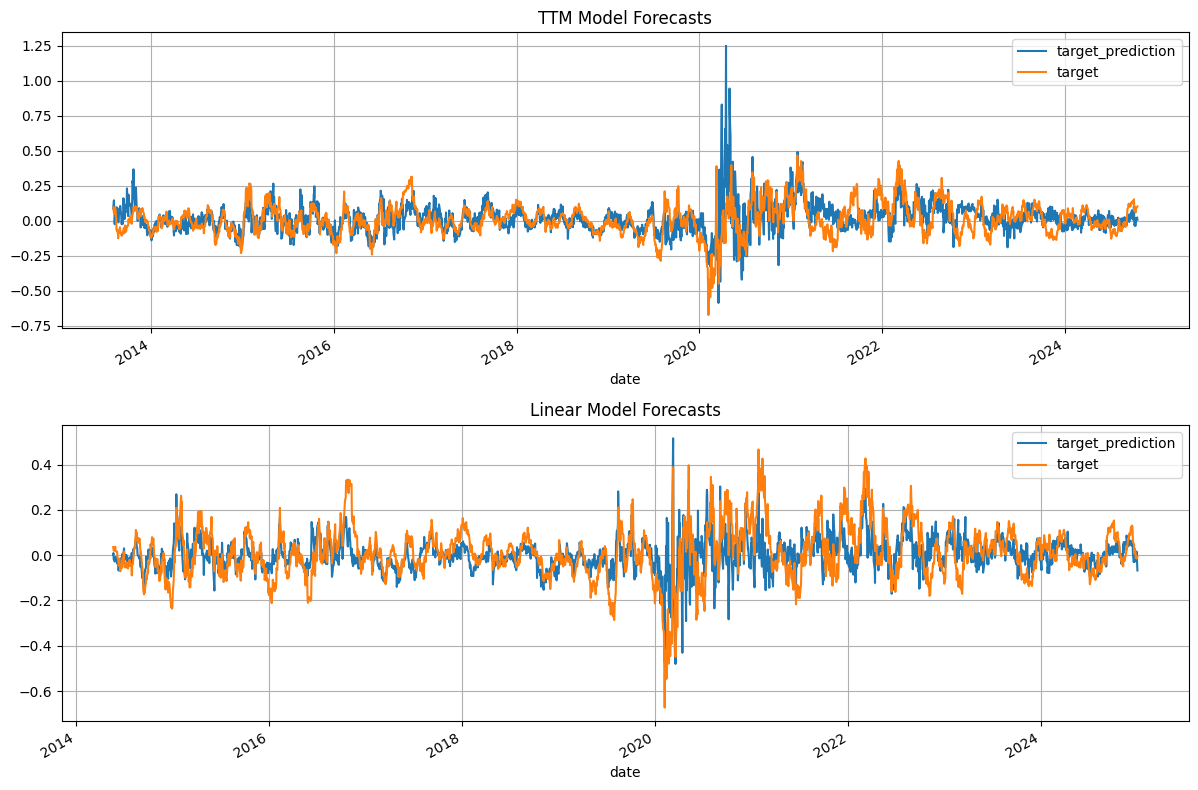

In [250]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
all_forecasts_ttm.plot(ax=ax1)
ax1.set_title('TTM Model Forecasts')
ax1.grid(True)

all_forecasts_linear.plot(ax=ax2)
ax2.set_title('Linear Model Forecasts')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Metrics

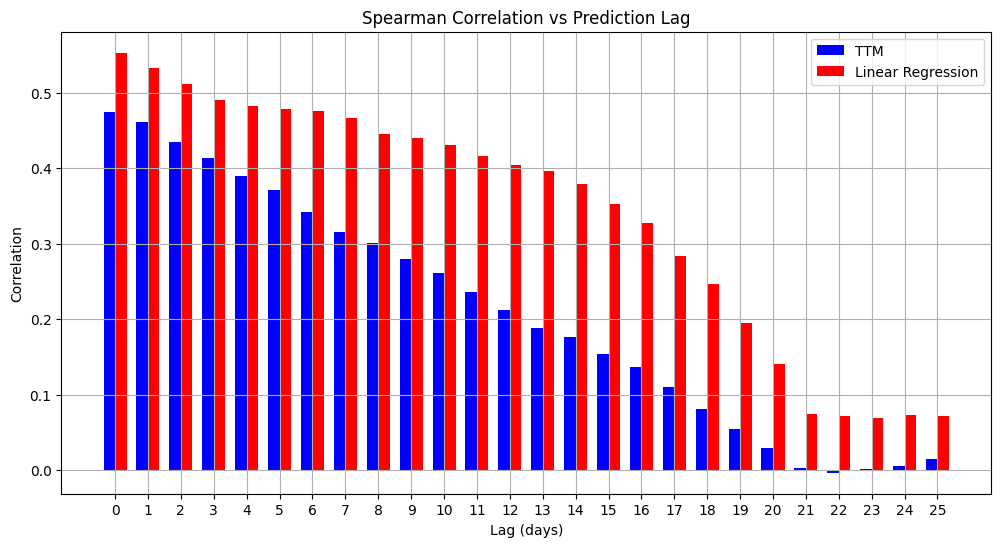

In [251]:
# Calculate correlations for different lags
lags = range(0, 26)
lag_correlations = []
lag_correlations_linear = []

for lag in lags:
    # Shift predictions by lag days for TTM
    lagged_predictions = all_forecasts_ttm['target_prediction'].shift(lag)
    correlation = all_forecasts_ttm['target'].corr(lagged_predictions, method='spearman')
    lag_correlations.append(correlation)
    
    # Shift predictions by lag days for Linear
    lagged_predictions_linear = all_forecasts_linear['target_prediction'].shift(lag)
    correlation_linear = all_forecasts_linear['target'].corr(lagged_predictions_linear, method='spearman')
    lag_correlations_linear.append(correlation_linear)

# Create bar plot with side-by-side bars
plt.figure(figsize=(12, 6))
x = np.arange(len(lags))
width = 0.35

plt.bar(x - width/2, lag_correlations, width, label='TTM', color='blue')
plt.bar(x + width/2, lag_correlations_linear, width, label='Linear Regression', color='red')

plt.title('Spearman Correlation vs Prediction Lag')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.xticks(x, lags)
plt.legend()
plt.grid(True)
plt.show()


In [256]:
model_mse = ((all_forecasts_linear.target-all_forecasts_linear.target_prediction)**2).mean()
print(f'Linear Regression MSE: {np.round(model_mse, 5)}')

model_mse = ((all_forecasts_ttm.target-all_forecasts_ttm.target_prediction)**2).mean()
print(f'TTM MSE: {np.round(model_mse, 5)}')

naive_mse = np.mean(all_forecasts_linear.target**2)
print(f'Naive MSE: {np.round(naive_mse, 5)}')

model_mse = ((all_forecasts_linear.target-all_forecasts_linear.target_prediction)**2).median()
print(f'Linear Regression Median Squared Error: {np.round(model_mse, 5)}')

model_mse = ((all_forecasts_ttm.target-all_forecasts_ttm.target_prediction)**2).median()
print(f'TTM Median Squared Error: {np.round(model_mse, 5)}')

naive_mse = np.median(all_forecasts_linear.target**2)
print(f'Naive Median Squared Error: {np.round(naive_mse, 5)}')

Linear Regression MSE: 0.0083
TTM MSE: 0.01167
Naive MSE: 0.0131
Linear Regression Median Squared Error: 0.00263
TTM Median Squared Error: 0.00317
Naive Median Squared Error: 0.00387


## Directional Accuracy


In [257]:
directional_accuracy_ttm = np.mean(np.sign(all_forecasts_ttm['target']) == np.sign(all_forecasts_ttm['target_prediction']))
print(f'Directional Accuracy TTM: {directional_accuracy_ttm:.4f}')

directional_accuracy_linear = np.mean(np.sign(all_forecasts_linear['target']) == np.sign(all_forecasts_linear['target_prediction']))
print(f'Directional Accuracy TTM: {directional_accuracy_linear:.4f}')

Directional Accuracy TTM: 0.6512
Directional Accuracy TTM: 0.6799


## Betas Evolution (linear regression)

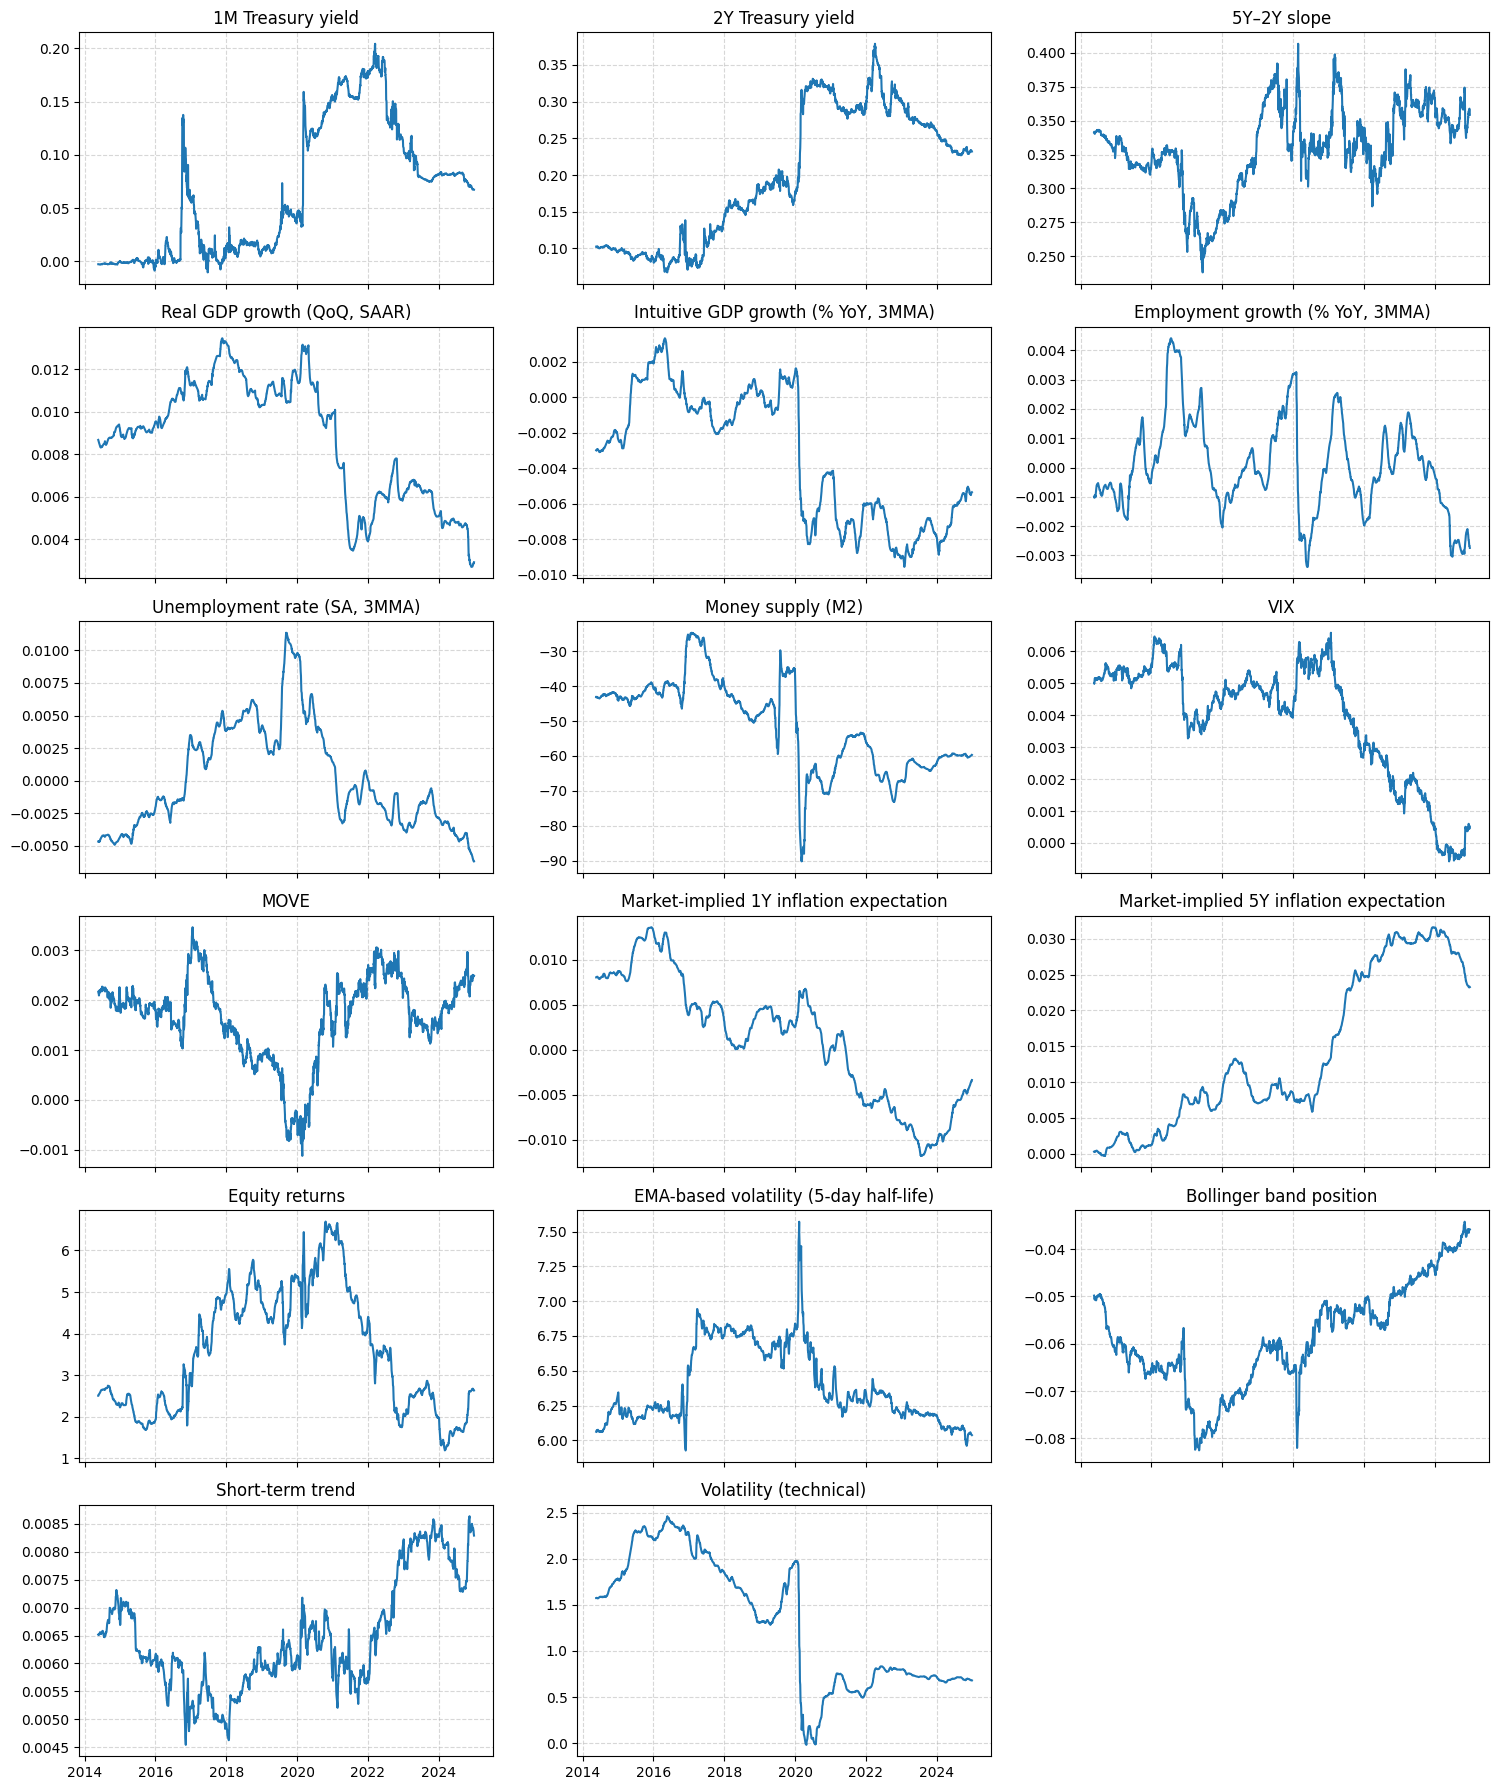

In [258]:
coefs_history.rename(columns=column_rename_dict, inplace=True)

n_plots = coefs_history.shape[1]
n_cols = 3
n_rows = -(-n_plots // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True)
axes = axes.flatten()

for idx, col in enumerate(coefs_history.columns):
    axes[idx].plot(coefs_history.index, coefs_history[col], linestyle='-')
    axes[idx].set_title(col)
    axes[idx].grid(True, linestyle='--', alpha=0.5)

for idx in range(len(coefs_history.columns), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## Backtest on target variable

In [281]:
start_date = "2015-01-01"
end_date = "2024-10-16"

### TTM

,Total Return,CAGR,Volatility,Sharpe,Max Drawdown,Information Ratio
10Y_fixed_vol,86.63%,6.71%,48.40%,0.37,-83.88%,0.00
signal1,438.84%,19.15%,10.23%,1.76,-15.01%,0.00
signal2,440.45%,19.19%,10.25%,1.76,-15.03%,0.00
signal3,616.87%,22.75%,10.22%,2.06,-15.36%,0.06
10Y_dynamic_vol,3.05%,0.31%,15.94%,0.10,-56.86%,-0.49


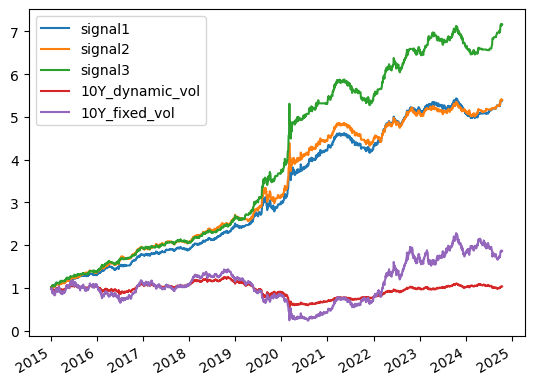

In [282]:
# Trading Strats TTM
preds = all_forecasts_ttm['target_prediction']
rolling_exp_mean = preds.ewm(span=21).mean()
rolling_mean = preds.rolling(21).mean()
signal1 = rolling_mean.apply(lambda x: np.sign(x) if np.abs(x) > 0.01 else 0)
signal2 = rolling_exp_mean.apply(lambda x: np.sign(x) if np.abs(x) > 0.01 else 0)
signal3 = np.sign(preds).rolling(21).sum().apply(lambda x: np.sign(x) if np.abs(x) > 6 else 0)
signals = pd.concat([signal1, signal2, signal3], axis=1)
signals = signals.dropna()
signals.columns = ['signal1', 'signal2', 'signal3']

# Calculate returns and volatility
target = curve_data['10 Yr']
target_ret = target.pct_change().shift(-2).dropna()
vol = target_ret.ewm(halflife=252).std()

# Align data
signals = signals.loc[signals.index.intersection(target_ret.index)]
vol = vol.loc[signals.index]
target_ret = target_ret.loc[signals.index]

# Calculate weighted returns
weighted_returns = signals.multiply(target_ret, axis=0)#.div(vol, axis=0)

# Calculate dynamic scaling constant to target specific volatility
target_vol_signal = 0.1
target_vol_benchmark = 0.01
realized_vol = weighted_returns.ewm(halflife=252).std() * np.sqrt(252)
scaling_constant = target_vol_signal / realized_vol

returns = (weighted_returns * scaling_constant).dropna()
returns['10Y_dynamic_vol'] = target_ret / vol * target_vol_benchmark
returns['10Y_fixed_vol'] = target_ret
returns = returns.loc[start_date:end_date].dropna()
cum_returns = (1+returns).cumprod()
cum_returns.plot()

perf_df = compute_performance_metrics(returns, benchmark_col="10Y_fixed_vol")
perf_df.style.format({
    'Total Return': '{:.2%}',
    'CAGR':         '{:.2%}',
    'Volatility':   '{:.2%}',
    'Sharpe':       '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'Information Ratio': '{:.2f}'
})


## Linear Regression

,Total Return,CAGR,Volatility,Sharpe,Max Drawdown,Information Ratio
10Y_fixed_vol,86.63%,6.71%,48.40%,0.37,-83.88%,0.00
signal1,680.29%,23.83%,10.07%,2.17,-15.09%,0.07
signal2,329.48%,16.37%,10.02%,1.56,-15.11%,-0.05
signal3,679.30%,23.82%,10.01%,2.18,-13.09%,0.07
10Y_dynamic_vol,3.05%,0.31%,15.94%,0.10,-56.86%,-0.49


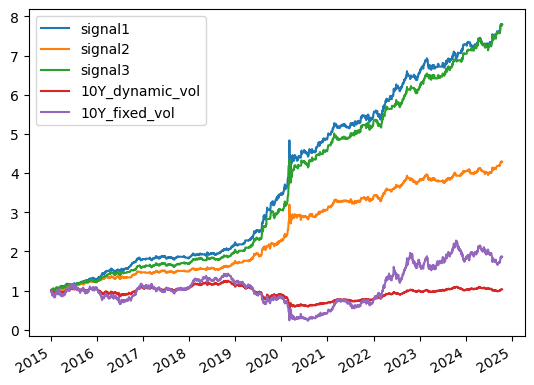

In [283]:
# Trading Strats Linear Regression
preds = all_forecasts_linear['target_prediction']
rolling_exp_mean = preds.ewm(span=21).mean()
rolling_mean = preds.rolling(21).mean()
signal1 = rolling_mean.apply(lambda x: np.sign(x) if np.abs(x) > 0.01 else 0)
signal2 = rolling_exp_mean.apply(lambda x: np.sign(x) if np.abs(x) > 0.01 else 0)
signal3 = np.sign(preds).rolling(21).sum().apply(lambda x: np.sign(x) if np.abs(x) > 6 else 0)
signals = pd.concat([signal1, signal2, signal3], axis=1)
signals = signals.dropna()
signals.columns = ['signal1', 'signal2', 'signal3']

# Calculate returns and volatility
target = curve_data['10 Yr']
target_ret = target.pct_change().shift(-2).dropna()
vol = target_ret.ewm(halflife=252).std()

# Align data
signals = signals.loc[signals.index.intersection(target_ret.index)]
vol = vol.loc[signals.index]
target_ret = target_ret.loc[signals.index]

# Calculate weighted returns
weighted_returns = signals.multiply(target_ret, axis=0)

# Calculate dynamic scaling constant to target specific volatility
target_vol_signal = 0.1
target_vol_benchmark = 0.01
realized_vol = weighted_returns.ewm(halflife=252).std() * np.sqrt(252)
scaling_constant = target_vol_signal / realized_vol

returns =( weighted_returns * scaling_constant).dropna()
returns['10Y_dynamic_vol'] = target_ret / vol * target_vol_benchmark
returns['10Y_fixed_vol'] = target_ret
returns = returns.loc[start_date:end_date].dropna()
cum_returns = (1+returns).cumprod()
cum_returns.plot()


perf_df = compute_performance_metrics(returns, benchmark_col="10Y_fixed_vol")
perf_df.style.format({
    'Total Return': '{:.2%}',
    'CAGR':         '{:.2%}',
    'Volatility':   '{:.2%}',
    'Sharpe':       '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'Information Ratio': '{:.2f}'
})